# Notes

- With Wirtinger calculus for real-valued Loss functions (L: C->R), the total derivative is completely determined by
just one of the Wirtinger derivatives. This is because dL/dz = 0 iff. L depends only on conj(z), and vice versa. \
  - For L(z) = abs(z)^2 = z*conj(z), dL/dz = conj(z), and dL/dconj(z) = z

In [160]:
import cmath

class ComplexValue:
    def __init__(self, z, _children=(), _op='', label=''):
        self.z = complex(z)
        self.real = self.z.real
        self.imag = self.z.imag
        self.label = label

        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def real_part(self):
        out = ComplexValue(self.z.real, (self,), 'real')
        def _backward():
            self.grad += 1 * out.grad
        out._backward = _backward
        return out

    def imag_part(self):
        out = ComplexValue(self.z.imag, (self,), 'imag')
        def _backward():
            self.grad += -1j * out.grad
        out._backward = _backward
        return out

    def __add__(self, other):
        other = other if isinstance(other, ComplexValue) else ComplexValue(other)
        out = ComplexValue(self.z + other.z, (self, other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self.__add__(other)

    def __sub__(self, other):
        return self + (other * ComplexValue(-1))

    def __rsub__(self, other):
        return ComplexValue(other) - self

    def __mul__(self, other):
        other = other if isinstance(other, ComplexValue) else ComplexValue(other)
        out = ComplexValue(self.z * other.z, (self, other), '*')
        def _backward():
            self.grad += other.z.conjugate() * out.grad
            other.grad += self.z.conjugate() * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        other = other if isinstance(other, ComplexValue) else ComplexValue(other)
        out = ComplexValue(self.z / other.z, (self, other), '/')
        def _backward():
            self.grad += (1 / other.z.conjugate()) * out.grad
            other.grad += (-self.z / (other.z * other.z)).conjugate() * out.grad
        out._backward = _backward
        return out

    def __rtruediv__(self, other):
        return ComplexValue(other) / self

    def __pow__(self, exponent):
        if isinstance(exponent, (int, float, complex)):
            out = ComplexValue(self.z ** exponent, (self,), f'**{exponent}')
            def _backward():
                if self.z != 0:
                    self.grad += (exponent * self.z**(exponent - 1)).conjugate() * out.grad
            out._backward = _backward
            return out
        raise NotImplementedError("Only scalar exponents are supported")

    def zero_grad(self):
        self.grad = 0j

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for node in topo:
            node.zero_grad()
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __repr__(self):
        return f"ComplexValue(z={self.z}, grad={self.grad})"

    def conjugate(self): 
        return ComplexValue(self.z.conjugate(), (self,), 'conj')


In [161]:
c = ComplexValue(2 + 3j)
loss = c.real_part() * c.real_part() + c.imag_part() * c.imag_part()
loss.backward()
print(f"Loss: {loss}")         # Should be ~13.0
print(f"Gradient: {c.grad}")   # Should be ≈ 2 + 6j


Loss: ComplexValue(z=(13+0j), grad=1.0)
Gradient: (4-6j)


In [121]:
def modReLU(z: ComplexValue, bias=0.0) -> ComplexValue:
    abs_z = abs(z.z)
    thresholded = max(0.0, abs_z + bias)
    out_z = 0.0 if abs_z == 0 else thresholded * z.z / abs_z
    out = ComplexValue(out_z, (z,), 'modReLU')

    def _backward():
        if abs_z == 0 or thresholded == 0.0:
            return
        dReLU = 1.0 if abs_z + bias > 0 else 0.0
        z_unit = z.z / abs_z
        dz = dReLU * (1 - thresholded / abs_z) * z_unit + dReLU * z_unit
        z.grad += dz * out.grad
    out._backward = _backward

    return out

In [122]:
class Neuron:
    def __init__(self, nin, activation=True):
        self.w = [ComplexValue(complex(random.uniform(-1,1), random.uniform(-1,1))) for _ in range(nin)]
        self.b = ComplexValue(complex(random.uniform(-1,1), random.uniform(-1,1)))
        self.activation = activation

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        return modReLU(act) if self.activation else act

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout, activation=True):
        self.neurons = [Neuron(nin, activation=activation) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], activation=(i < len(nouts)-1)) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [164]:

def train(model, x_train, y_train, lr=0.01, epochs=100):
    loss_history = []
    
    for epoch in range(epochs):
        
        # Forward pass
        y_pred = model(x_train)
        loss = sum((yp - yt) * (yp - yt).conjugate() for yp, yt in zip(y_pred, y_train))  # MSE
        
        # Backward pass
        loss.backward()

        # Gradient update
        for p in model.parameters():
            p.z -= lr * p.grad

        # Logging
        loss_history.append(loss.z.real)
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.z.real:.4f}")
    
    return loss_history

Epoch 0/1000, Loss: 102.5558
Epoch 100/1000, Loss: 15.6939
Epoch 200/1000, Loss: 2.7207
Epoch 300/1000, Loss: 0.4338
Epoch 400/1000, Loss: 0.0738
Epoch 500/1000, Loss: 0.0133
Epoch 600/1000, Loss: 0.0025
Epoch 700/1000, Loss: 0.0005
Epoch 800/1000, Loss: 0.0001
Epoch 900/1000, Loss: 0.0000


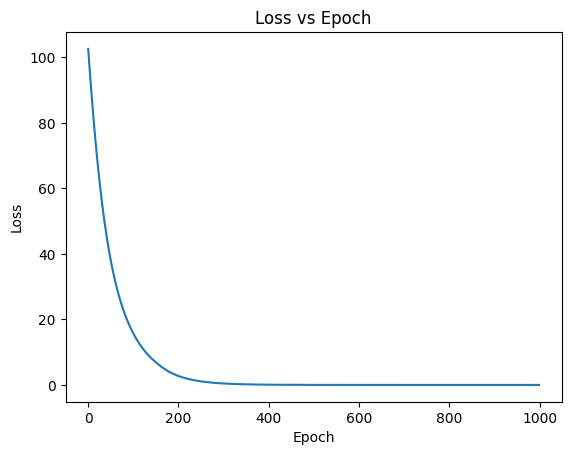

In [165]:
import matplotlib.pyplot as plt

x_train = [ComplexValue(complex(1 + 2j)), ComplexValue(complex(2 + 3j))]  # complex inputs
y_train = [ComplexValue(complex(4 + 5j)), ComplexValue(complex(5 + 7j))]  # complex outputs

# Initialize model
model = MLP(1, [4, 4, 1])

# Train model
loss_history = train(model, x_train, y_train, lr=0.0001, epochs=1000)

# Plot loss
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()

Would a CVNN outperform a real-valued NN on tasks involving rotation?

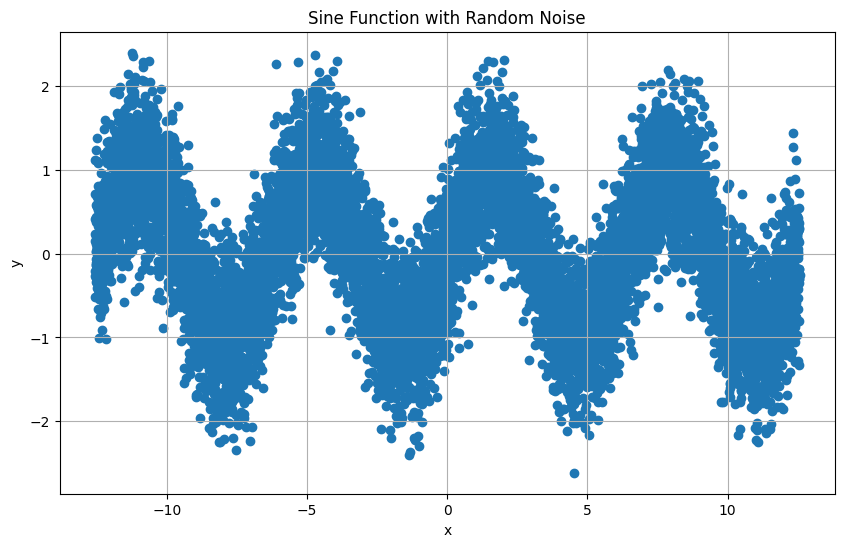

In [166]:
#dependencies 
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim

#generating and visualizing dataset
x = np.linspace(-4 * np.pi, 4 * np.pi, 10000)
y = np.sin(x) + 0.5 * np.random.randn(len(x))

plt.figure(figsize=(10, 6))
plt.scatter(x, y)
plt.title("Sine Function with Random Noise")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [175]:
#transforming the input and output arrays to tensors
x_tensor = torch.from_numpy(x).float().view(-1, 1)
y_tensor = torch.from_numpy(y).float().view(-1, 1)

#implementing the model
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hidden = nn.Linear(1, 128)
    self.hidden2 = nn.Linear(128, 256)
    self.hidden3 = nn.Linear(256, 128)
    self.output = nn.Linear(128, 1)
  
  def forward(self, x):
    x = torch.relu(self.hidden(x))
    x = torch.relu(self.hidden2(x))
    x = torch.relu(self.hidden3(x))
    x = self.output(x)
    return x

#instantiating the model, criterion (loss function), and optimizer
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

#training loop
num_epochs = 10000
for epoch in range(num_epochs):
  #forward pass
  outputs = model(x_tensor)
  loss = criterion(outputs, y_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (epoch + 1) % 100 == 0:
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

#inference and visualization

# Test the trained model
with torch.no_grad():
    predicted = model(x_tensor)

# Plot the original function and the learned function
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Original Function')
plt.plot(x, predicted.numpy(), color='red', label='Learned Function')
plt.title("Original Function vs. Learned Function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

TypeError: linear(): argument 'input' (position 1) must be Tensor, not list

Epoch [100/10000], Loss: ComplexValue(z=0j, grad=1.0)
Epoch [200/10000], Loss: ComplexValue(z=0j, grad=1.0)
Epoch [300/10000], Loss: ComplexValue(z=0j, grad=1.0)
Epoch [400/10000], Loss: ComplexValue(z=0j, grad=1.0)
Epoch [500/10000], Loss: ComplexValue(z=0j, grad=1.0)
Epoch [600/10000], Loss: ComplexValue(z=0j, grad=1.0)
Epoch [700/10000], Loss: ComplexValue(z=0j, grad=1.0)
Epoch [800/10000], Loss: ComplexValue(z=0j, grad=1.0)
Epoch [900/10000], Loss: ComplexValue(z=0j, grad=1.0)
Epoch [1000/10000], Loss: ComplexValue(z=0j, grad=1.0)
Epoch [1100/10000], Loss: ComplexValue(z=0j, grad=1.0)
Epoch [1200/10000], Loss: ComplexValue(z=0j, grad=1.0)
Epoch [1300/10000], Loss: ComplexValue(z=0j, grad=1.0)
Epoch [1400/10000], Loss: ComplexValue(z=0j, grad=1.0)
Epoch [1500/10000], Loss: ComplexValue(z=0j, grad=1.0)
Epoch [1600/10000], Loss: ComplexValue(z=0j, grad=1.0)
Epoch [1700/10000], Loss: ComplexValue(z=0j, grad=1.0)
Epoch [1800/10000], Loss: ComplexValue(z=0j, grad=1.0)
Epoch [1900/10000],

ValueError: x and y must have same first dimension, but have shapes (10000,) and (1,)

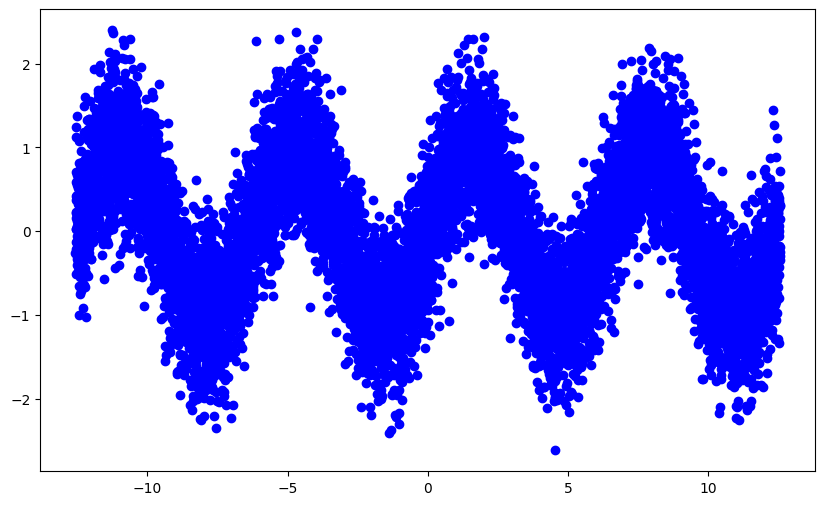

In [176]:
x_tensor = torch.from_numpy(x).float().view(-1, 1)
x_tensor = [ComplexValue(complex(val.item(), 0.0)) for val in x_tensor.view(-1)]
y_tensor = torch.from_numpy(y).float().view(-1, 1)


model = MLP(1, [4, 4, 1])

#training loop
num_epochs = 10000
for epoch in range(num_epochs):


  y_pred = model(x_train)
  loss = sum((yp - yt) * (yp - yt).conjugate() for yp, yt in zip(y_pred, y_train))  # MSE

  # Backward pass
  loss.backward()

  # Gradient update
  for p in model.parameters():
    p.z -= lr * p.grad  

  if (epoch + 1) % 100 == 0:
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss}")

#inference and visualization

# Test the trained model
with torch.no_grad():
    predicted = model(x_tensor)

# Plot the original function and the learned function
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Original Function')
plt.plot(x, np.array(predicted), color='red', label='Learned Function')
plt.title("Original Function vs. Learned Function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()